In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from llm_ran.llm import models


In [21]:
df = pd.read_csv("../data/llm_ran_kubernetes_base.csv")
# df = df[df["model"] != models.LLAMA_33_70B]
# df['model'] = df['model'].str.replace("-instruct-q3_K_M", "")
df.groupby(["model", "graph"]).agg({"success": "mean", "equal": "mean"})

success     equal
model                       graph                      
llama3.1:8b                 codegen  0.114286  0.014286
                            direct   0.428571  0.092857
llama3.3:70b-instruct-q2_K  codegen  0.000000  0.000000
                            direct   0.535714  0.285714
qwen2.5:14b                 codegen  0.914286  0.664286
                            direct   0.857143  0.742857
qwen2.5:32b-instruct-q3_K_M codegen  0.985714  0.850000
                            direct   1.000000  1.000000
qwen2.5:7b                  codegen  0.542857  0.335714
                            direct   0.857143  0.728571

In [22]:
_df = df.copy()
_df['try'] = _df['try'] % 4
simdf = _df.groupby(["model", "graph", "try"]).agg({"success": "mean", "equal": "mean"})
simdf

success     equal
model                       graph   try                    
llama3.1:8b                 codegen 0    0.142857  0.000000
                                    1    0.085714  0.000000
                                    2    0.142857  0.028571
                                    3    0.085714  0.028571
                            direct  0    0.428571  0.142857
                                    1    0.342857  0.028571
                                    2    0.485714  0.057143
                                    3    0.457143  0.142857
llama3.3:70b-instruct-q2_K  codegen 0    0.000000  0.000000
                                    1    0.000000  0.000000
                                    2    0.000000  0.000000
                                    3    0.000000  0.000000
                            direct  0    0.600000  0.342857
                                    1    0.514286  0.257143
                                    2    0.485714  0.285714
                                    3    0.542857  0.257143
qwen2.5:14b                 codegen 0    0.942857  0.628571
                                    1    0.857143  0.628571
                                    2    0.942857  0.714286
                                    3    0.914286  0.685714
                            direct  0    0.857143  0.800000
                                    1    0.857143  0.657143
                                    2    0.857143  0.771429
                                    3    0.857143  0.742857
qwen2.5:32b-instruct-q3_K_M codegen 0    0.971429  0.828571
                                    1    1.000000  0.885714
                                    2    0.971429  0.828571
                                    3    1.000000  0.857143
                            direct  0    1.000000  1.000000
                                    1    1.000000  1.000000
                                    2    1.000000  1.000000
                                    3    1.000000  1.000000
qwen2.5:7b                  codegen 0    0.628571  0.371429
                                    1    0.485714  0.228571
                                    2    0.485714  0.371429
                                    3    0.571429  0.371429
                            direct  0    0.857143  0.771429
                                    1    0.857143  0.714286
                                    2    0.857143  0.771429
                                    3    0.857143  0.657143

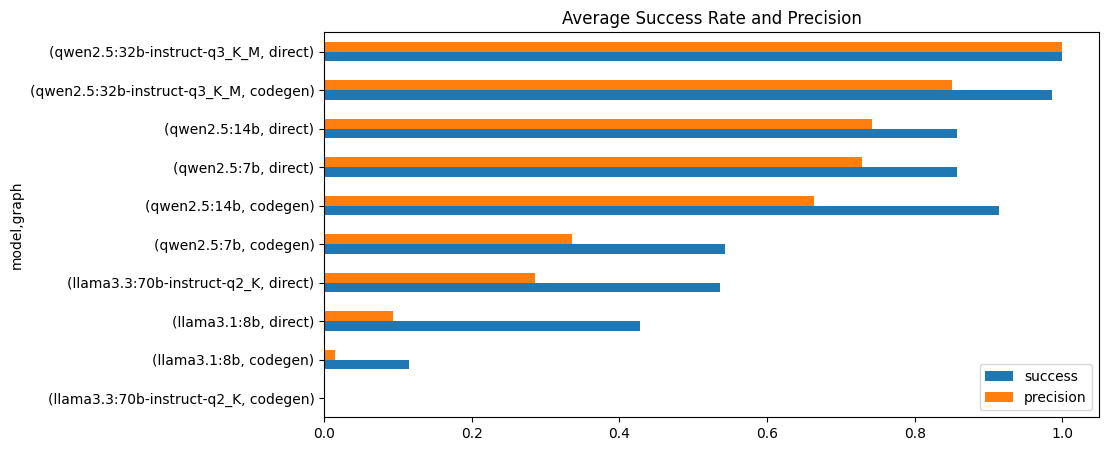

success           precision          
                                         mean       std      mean       std
model                       graph                                          
llama3.1:8b                 codegen  0.114286  0.319300  0.014286  0.119092
                            direct   0.428571  0.496649  0.092857  0.291274
llama3.3:70b-instruct-q2_K  codegen  0.000000  0.000000  0.000000  0.000000
                            direct   0.535714  0.500514  0.285714  0.453376
qwen2.5:14b                 codegen  0.914286  0.280947  0.664286  0.473935
                            direct   0.857143  0.351184  0.742857  0.438628
qwen2.5:32b-instruct-q3_K_M codegen  0.985714  0.119092  0.850000  0.358354
                            direct   1.000000  0.000000  1.000000  0.000000
qwen2.5:7b                  codegen  0.542857  0.499949  0.335714  0.473935
                            direct   0.857143  0.351184  0.728571  0.446293

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
# err = df.groupby(["model", "graph"]).agg({"equal": "std", "success": "std"})
_df = (
    df.groupby(["model", "graph"])
    .agg({"success": ["mean", "std"], "equal": ["mean", "std"]})
    .rename({"equal": "precision"}, axis=1)
    # .plot(kind='barh', ax=ax, ylim=(0, 1), yerr="std", title="Average Success Rate and Precision")
)
(
    _df.xs("mean", axis=1, level=1)
    .sort_values("precision")
    .plot(
        kind='barh', ax=ax, ylim=(0, 1), 
        title="Average Success Rate and Precision",
        # xerr=_df.xs("std", axis=1, level=1),
    )
)
plt.show()
_df

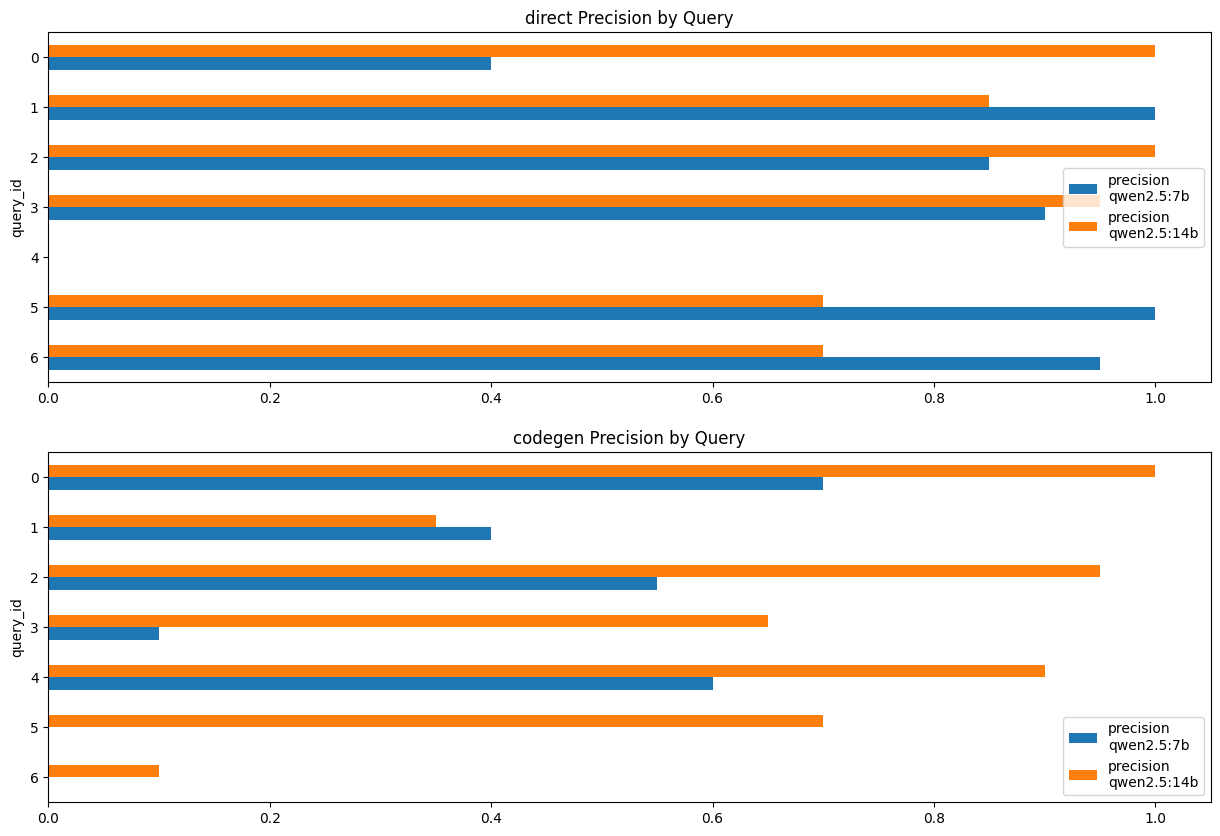

In [24]:
_mdls = [
    models.QWEN_25_7B,
    models.QWEN_25_14B,
    # models.QWEN_25_32B,
    # "qwen2.5:32b",
]
fig, ax = plt.subplots(nrows=len(df['graph'].unique()), figsize=(15, 10))
for i, g in enumerate(df['graph'].unique()):
    _total = pd.DataFrame()
    for _, _mdl in enumerate(_mdls):
        _df = (
            df[(df['graph'] == g) & (df['model'] == _mdl)]
            .groupby(["query_id"])
            .agg({"equal": "mean"})
            .rename({"equal": f"precision\n{_mdl}"}, axis=1)
        )
        _total = pd.concat([_total, _df], axis=1)
    (
        _total
        .sort_values("query_id", ascending=False)
        .plot(
            kind='barh', ax=ax[i], ylim=(0, 1),
            title=f"{g} Precision by Query",
        )
    )
plt.show()
# _total

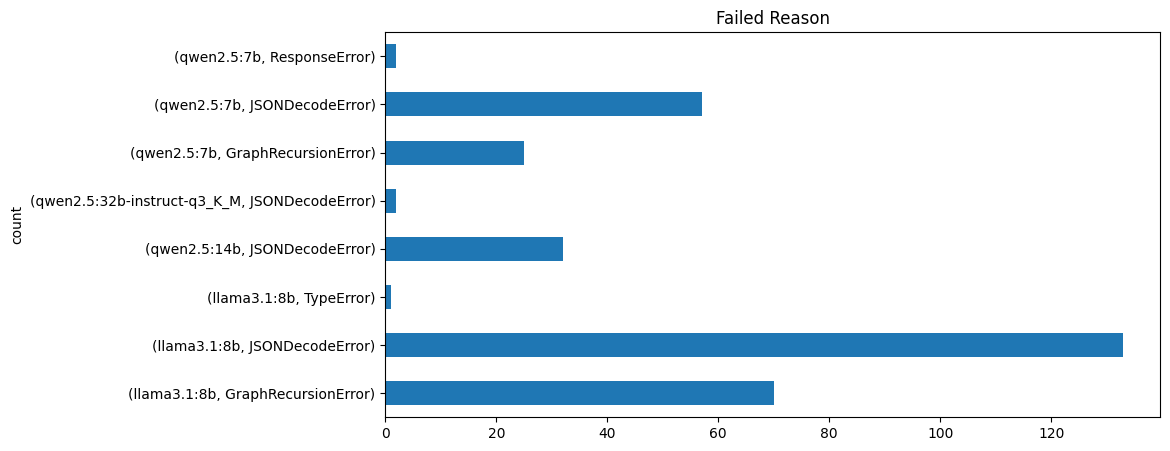

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

(
    df[df['success'] == False]
    .groupby(["model", "failed_reason"])
    .count()['query_id']
    .plot(kind='barh', ylabel="count", ax=ax, title="Failed Reason")
)
plt.show()